In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

In [2]:
# /media/juneyonglee/My Book/data/Chl-a/test/0/UST21_L3_Merged-Chla-1D_20210102_r5632_c2304.tiff
# /media/juneyonglee/My Book/Preprocessed/UST/Chl-a_8day/train/90/2012_01_20_sae.tiff
# img = input()
# img = cv2.imread(img,cv2.IMREAD_UNCHANGED)
# plt.imshow(img)
# plt.axis(False)
# plt.colorbar()


In [3]:
# np.sum(np.isnan(img))/(256**2)*100

현재 폴더: /home/juneyonglee/Documents
Loaded 20120109_nak_r3973_c4703.tiff with shape (256, 256) and dtype uint16
20120109_nak_r3973_c4703.tiff 전체 NaN 값 비율: 0.00%
20120109_nak_r3973_c4703.tiff 0 값 비율: 16.68%
20120109_nak_r3973_c4703.tiff 육지를 제외한 해양 영역 NaN 비율: 0.00%


/tmp/ipykernel_2695800/2584858522.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap('viridis', 256)  # 256개 색상 사용


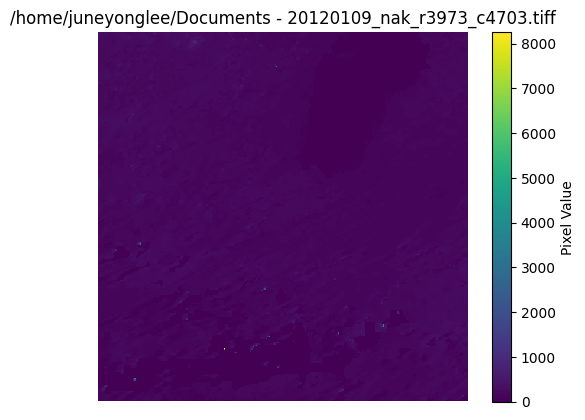

Loaded 20120109_nak_r3995_c4737.tiff with shape (256, 256) and dtype uint16
20120109_nak_r3995_c4737.tiff 전체 NaN 값 비율: 0.00%
20120109_nak_r3995_c4737.tiff 0 값 비율: 14.97%
20120109_nak_r3995_c4737.tiff 육지를 제외한 해양 영역 NaN 비율: 0.00%


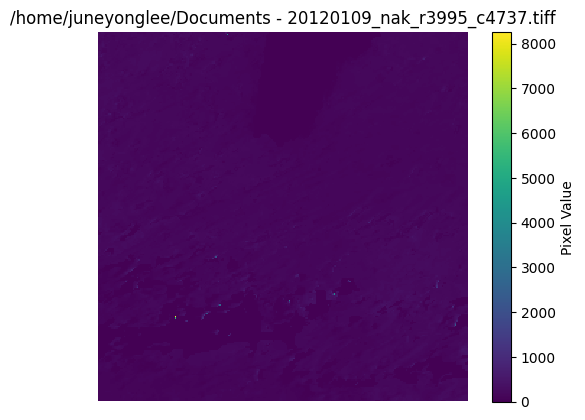

Loaded 20120227_nak_r3898_c4740.tiff with shape (256, 256) and dtype uint16
20120227_nak_r3898_c4740.tiff 전체 NaN 값 비율: 0.00%
20120227_nak_r3898_c4740.tiff 0 값 비율: 58.72%
20120227_nak_r3898_c4740.tiff 육지를 제외한 해양 영역 NaN 비율: 0.00%


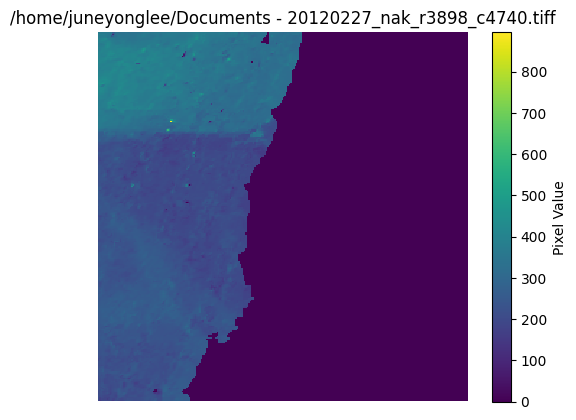

Loaded 20120109_nak_r3995_c4751.tiff with shape (256, 256) and dtype uint16
20120109_nak_r3995_c4751.tiff 전체 NaN 값 비율: 0.00%
20120109_nak_r3995_c4751.tiff 0 값 비율: 15.01%
20120109_nak_r3995_c4751.tiff 육지를 제외한 해양 영역 NaN 비율: 0.00%


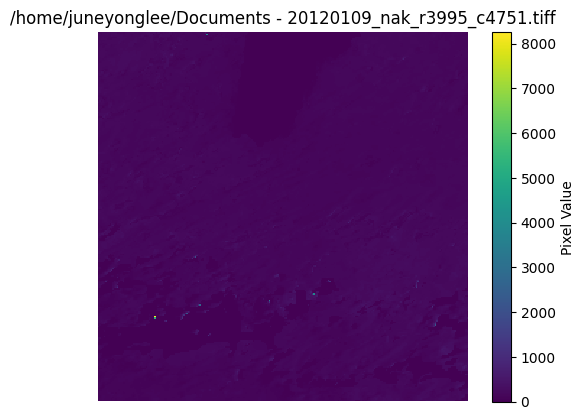

Loaded 20120227_nak_r3908_c4728.tiff with shape (256, 256) and dtype uint16
20120227_nak_r3908_c4728.tiff 전체 NaN 값 비율: 0.00%
20120227_nak_r3908_c4728.tiff 0 값 비율: 55.21%
20120227_nak_r3908_c4728.tiff 육지를 제외한 해양 영역 NaN 비율: 0.00%


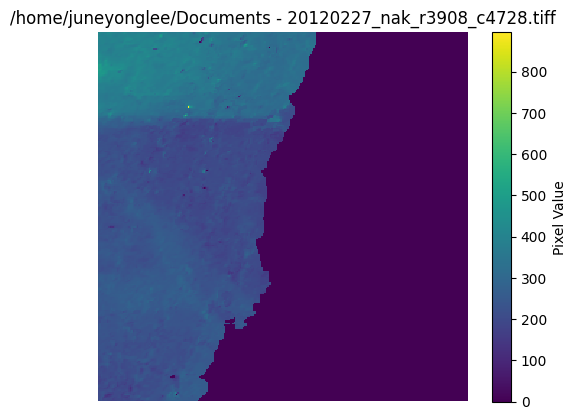

In [70]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff  # 수정

# 최상위 디렉토리 경로 설정
root_directory = "/home/juneyonglee/Documents"

# 사용자 정의 컬러맵 생성 (해양 데이터용)
def create_custom_cmap():
    viridis = plt.cm.get_cmap('viridis', 256)  # 256개 색상 사용
    return viridis

# 사용자 정의 컬러맵 설정
custom_cmap = create_custom_cmap()

# 디렉토리 내의 모든 하위 폴더와 파일을 순차적으로 처리
image_count = 0  # 출력할 이미지 카운터
max_images = 20  # 출력할 최대 이미지 수

for dirpath, dirnames, filenames in os.walk(root_directory):
    print(f"현재 폴더: {dirpath}")  # 현재 폴더 경로 출력
    
    # 해당 폴더 내의 모든 tiff 파일을 처리
    for filename in filenames:
        if filename.endswith(".tiff"):  # TIFF 파일만 선택
            file_path = os.path.join(dirpath, filename)
            
            # tifffile을 사용하여 이미지 불러오기 (16비트 이미지로 읽기)
            img = tiff.imread(file_path)

            if img is None:
                print(f"{filename} could not be loaded.")
                continue
            
            print(f"Loaded {filename} with shape {img.shape} and dtype {img.dtype}")

            # 999 값을 NaN으로 변환 (육지 부분을 NaN으로 치환)
            img = np.where(img == 999, np.nan, img)

            # 전체 픽셀 수 계산
            total_pixels = img.shape[0] * img.shape[1]
            
            # NaN 값 비율 계산 (전체 영역에서 NaN 비율)
            nan_count = np.count_nonzero(np.isnan(img))
            nan_ratio = (nan_count / total_pixels) * 100

            # 0 값 비율 계산
            zero_count = np.count_nonzero(img == 0)
            zero_ratio = (zero_count / total_pixels) * 100

            # 육지(999)를 제외한 영역에서 결측치 비율 계산 (해양 영역만 대상)
            ocean_mask = ~np.isnan(img)  # NaN이 아닌 영역을 마스크로 만듦
            valid_ocean_pixels = np.sum(ocean_mask)  # 유효한 해양 픽셀 수
            ocean_nan_count = np.sum(np.isnan(img) & ocean_mask)  # 육지를 제외한 NaN 수
            ocean_nan_ratio = (ocean_nan_count / valid_ocean_pixels) * 100 if valid_ocean_pixels > 0 else 0
            
            # 출력
            print(f"{filename} 전체 NaN 값 비율: {nan_ratio:.2f}%")
            print(f"{filename} 0 값 비율: {zero_ratio:.2f}%")
            print(f"{filename} 육지를 제외한 해양 영역 NaN 비율: {ocean_nan_ratio:.2f}%")
            
            # 해양 데이터 시각화 (육지 부분은 NaN으로 표시)
            plt.imshow(img, cmap=custom_cmap, interpolation='none')
            plt.axis('off')  # 축 제거
            plt.colorbar(label='Pixel Value')  # 컬러맵 바 추가
            plt.title(f"{dirpath} - {filename}")  # 폴더 경로와 파일명 출력

            plt.show()  # 각 이미지별로 별도 창으로 보여줌

            image_count += 1  # 이미지 카운터 증가
            if image_count >= max_images:  # 최대 이미지 수에 도달하면 종료
                break
    if image_count >= max_images:  # 상위 루프에서도 종료
        break


현재 폴더: /home/juneyonglee/Documents
파일명: 20120109_nak_r3973_c4703.tiff
전체 육지 픽셀 수: 4897
TIFF 이미지의 0 값과 겹치는 육지 픽셀 수: 4897
남은 육지 픽셀 수: 0


/tmp/ipykernel_2695800/4219737179.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap('viridis', 256)  # 256개 색상 사용


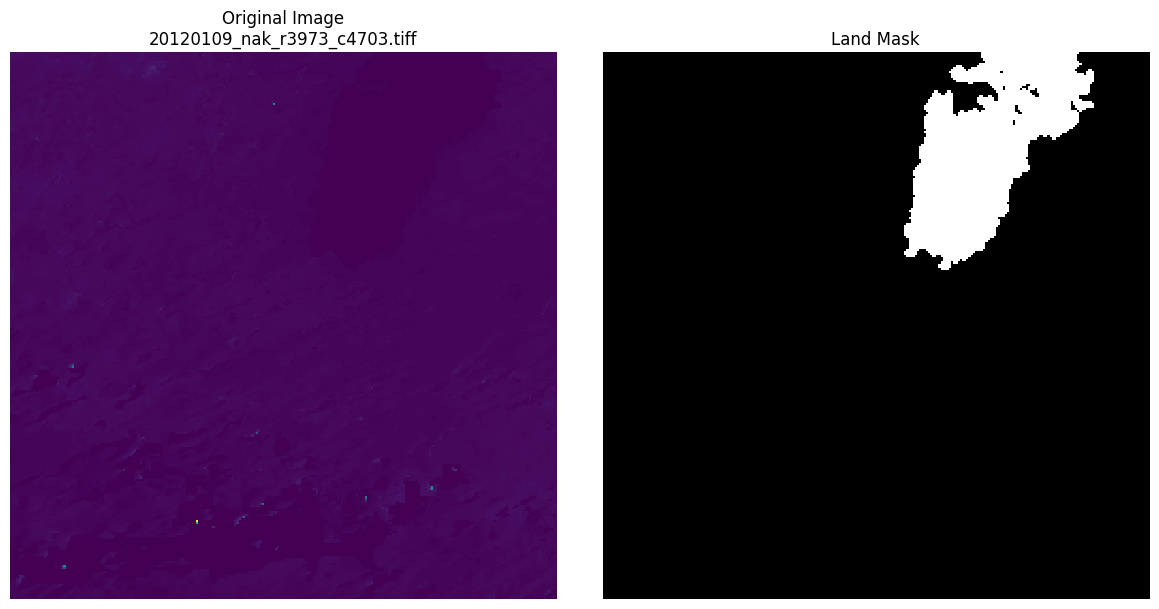

파일명: 20120109_nak_r3995_c4737.tiff
전체 육지 픽셀 수: 3772
TIFF 이미지의 0 값과 겹치는 육지 픽셀 수: 3772
남은 육지 픽셀 수: 0


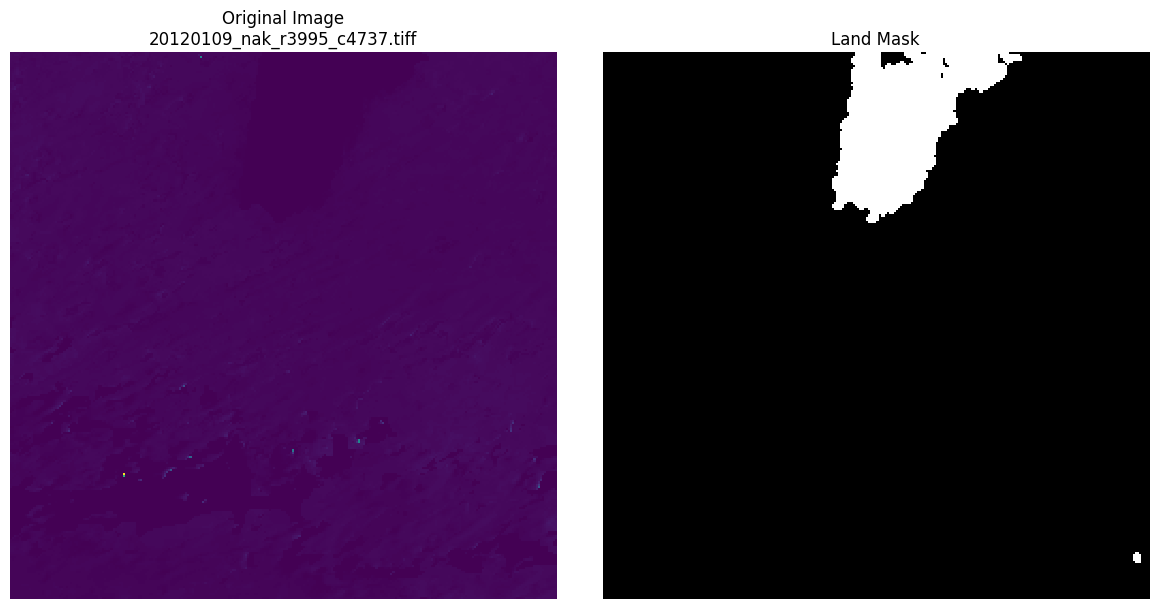

파일명: 20120227_nak_r3898_c4740.tiff
전체 육지 픽셀 수: 8851
TIFF 이미지의 0 값과 겹치는 육지 픽셀 수: 8851
남은 육지 픽셀 수: 0


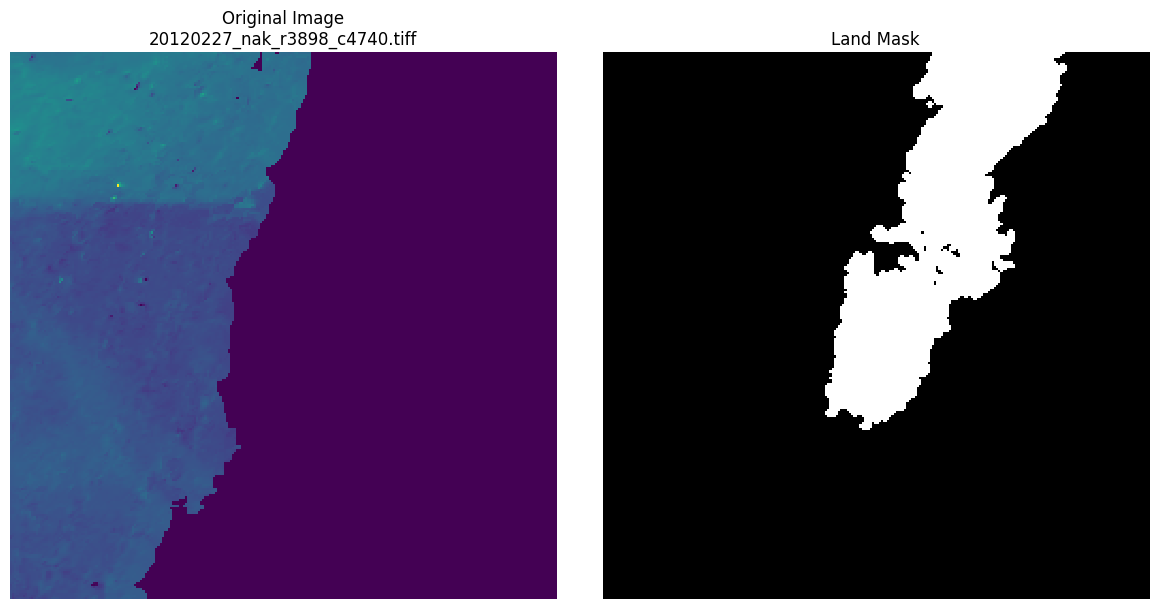

파일명: 20120109_nak_r3995_c4751.tiff
전체 육지 픽셀 수: 3772
TIFF 이미지의 0 값과 겹치는 육지 픽셀 수: 3772
남은 육지 픽셀 수: 0


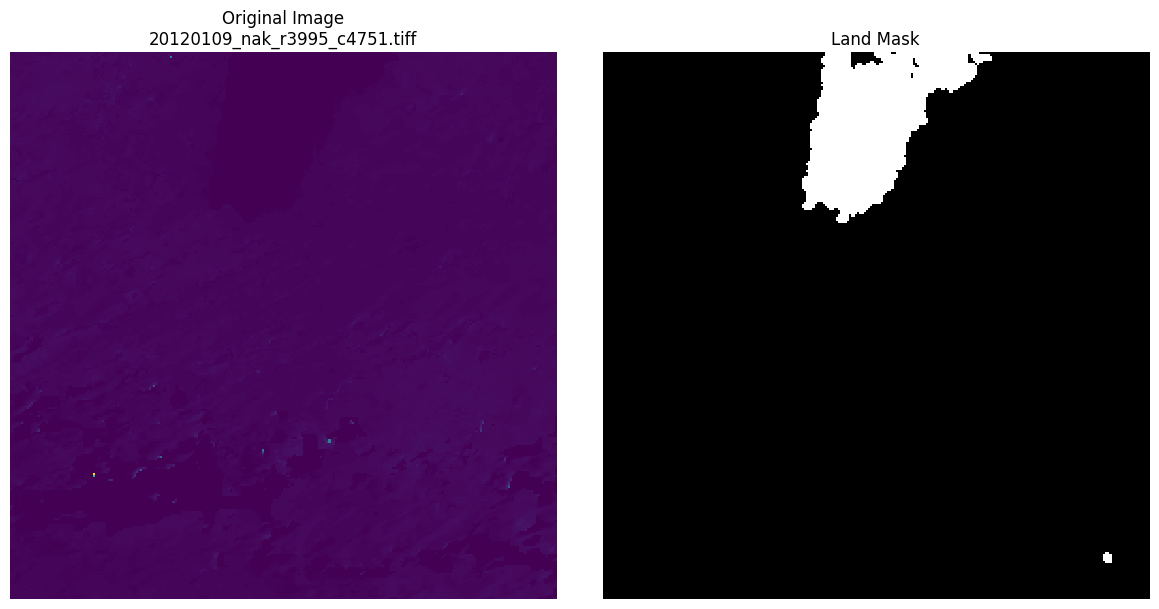

파일명: 20120227_nak_r3908_c4728.tiff
전체 육지 픽셀 수: 8224
TIFF 이미지의 0 값과 겹치는 육지 픽셀 수: 8224
남은 육지 픽셀 수: 0


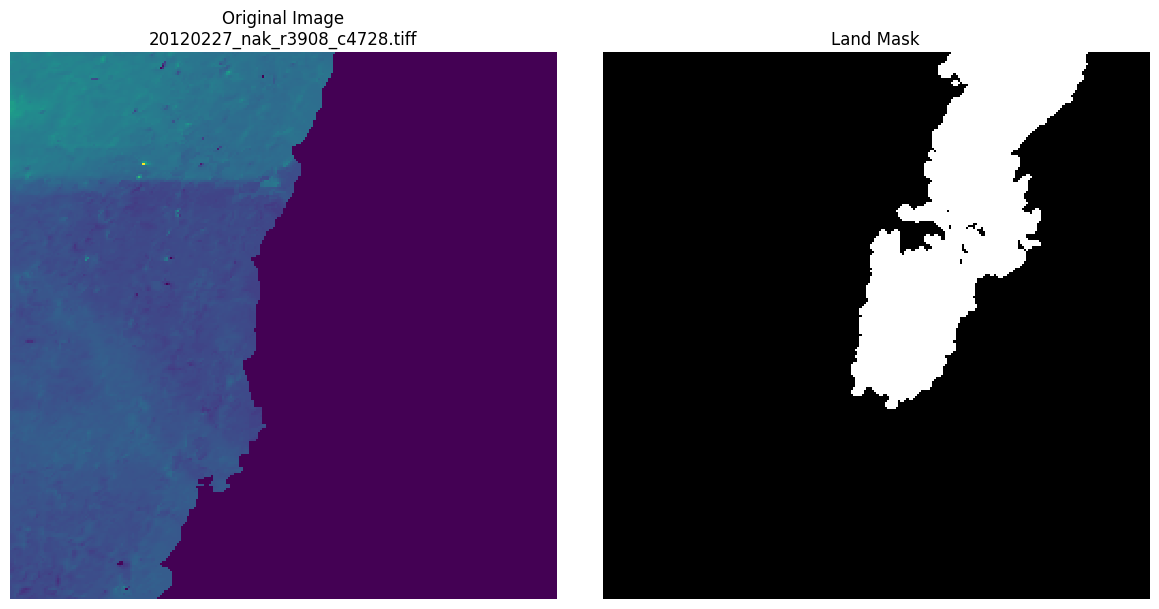

In [71]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.io import loadmat
import re  # 정규 표현식 사용

# 최상위 디렉토리 경로 설정
root_directory = "/home/juneyonglee/Documents"

# 육지/해양 마스크 파일 경로 설정
land_mask_path = "/home/juneyonglee/Desktop/AY_ust/preprocessing/Land_mask/Land_mask.mat"

# MATLAB 파일에서 육지/해양 마스크 불러오기
mat_data = loadmat(land_mask_path)
land_mask = mat_data['Land']  # 실제 MATLAB 파일 내의 변수명 사용

# 사용자 정의 컬러맵 생성 (해양 데이터용)
def create_custom_cmap():
    viridis = plt.cm.get_cmap('viridis', 256)  # 256개 색상 사용
    return ListedColormap(viridis(np.linspace(0, 1, 256)))

# 사용자 정의 컬러맵 설정
custom_cmap = create_custom_cmap()

# 행(row)과 열(col) 값을 파일명에서 추출하는 함수
def extract_row_col(filename):
    match = re.search(r'r(\d+)_c(\d+)', filename)
    if match:
        row = int(match.group(1))
        col = int(match.group(2))
        return row, col
    return None, None

# 디렉토리 내의 모든 하위 폴더와 파일을 순차적으로 처리
image_count = 0  # 출력할 이미지 카운터
max_images = 20  # 출력할 최대 이미지 수

for dirpath, dirnames, filenames in os.walk(root_directory):
    print(f"현재 폴더: {dirpath}")  # 현재 폴더 경로 출력
    
    # 해당 폴더 내의 모든 tiff 파일을 처리
    for filename in filenames:
        if filename.endswith(".tiff"):  # TIFF 파일만 선택
            file_path = os.path.join(dirpath, filename)
            
            # 파일명에서 행(row)과 열(col) 값 추출
            row, col = extract_row_col(filename)
            if row is None or col is None:
                continue  # 파일명에서 row, col 추출에 실패하면 건너뜀
            
            # 이미지 불러오기
            img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)

            # land_mask에서 해당 위치에 맞는 부분만 자르기 (img의 크기를 고려해서)
            mask_patch = land_mask[row:row+img.shape[0], col:col+img.shape[1]]
            
            if mask_patch.shape != img.shape:
                print(f"Warning: Mask patch shape {mask_patch.shape} does not match image shape {img.shape}")
                continue  # 마스크 패치 크기가 이미지와 맞지 않으면 건너뜀

            # 육지(1) 부분의 총 픽셀 수
            total_land_pixels = np.count_nonzero(mask_patch == 1)

            # TIFF 이미지에서 0인 값과 일치하는 육지 픽셀
            tiff_zero_mask = (img == 0)
            common_pixels = np.count_nonzero(tiff_zero_mask & (mask_patch == 1))

            # 육지에서 TIFF 이미지의 0과 겹치는 부분을 제외한 나머지 육지 픽셀 수
            remaining_land_pixels = total_land_pixels - common_pixels

            print(f"파일명: {filename}")
            print(f"전체 육지 픽셀 수: {total_land_pixels}")
            print(f"TIFF 이미지의 0 값과 겹치는 육지 픽셀 수: {common_pixels}")
            print(f"남은 육지 픽셀 수: {remaining_land_pixels}")
            
            # 2열로 그림을 그리기 위한 설정
            fig, axs = plt.subplots(1, 2, figsize=(12, 6))
            
            # 첫 번째 열: 원본 이미지
            axs[0].imshow(img, cmap=custom_cmap, interpolation='none')
            axs[0].set_title(f"Original Image\n{filename}")
            axs[0].axis('off')  # 축 제거
            
            # 두 번째 열: land_mask 이미지
            axs[1].imshow(mask_patch, cmap=ListedColormap(['black','white']), interpolation='none')
            axs[1].set_title("Land Mask")
            axs[1].axis('off')  # 축 제거
            
            # 그래프 출력
            plt.tight_layout()
            plt.show()

            image_count += 1  # 이미지 카운터 증가
            if image_count >= max_images:  # 최대 이미지 수에 도달하면 종료
                break
    if image_count >= max_images:  # 상위 루프에서도 종료
        break


/tmp/ipykernel_2695800/3557983012.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap('viridis', 256)  # 256개 색상 사용


현재 폴더: /home/juneyonglee/Documents
파일명: 20120109_nak_r3973_c4703.tiff
전체 픽셀 수: 65536
TIFF 이미지의 0 값 픽셀 수: 10929
TIFF 이미지의 0 값 비율: 16.68%


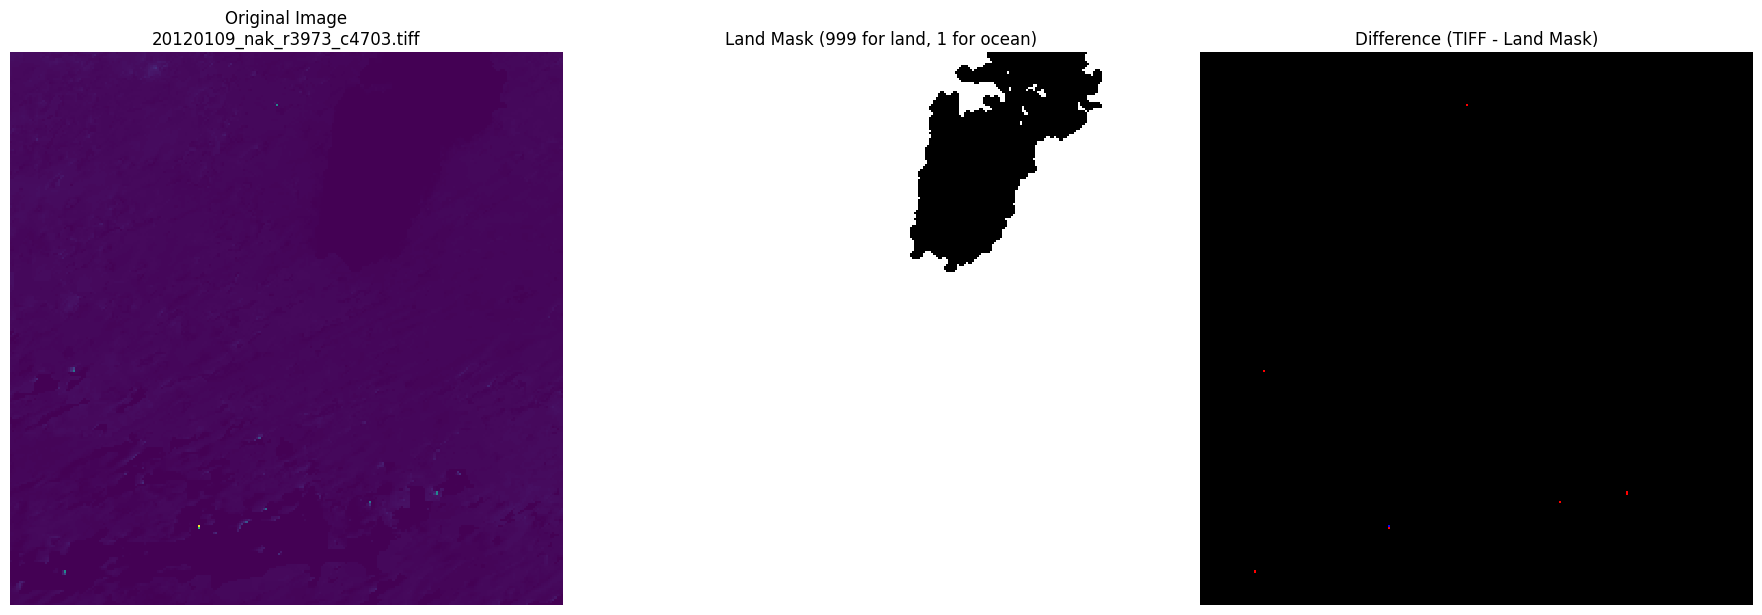

파일명: 20120109_nak_r3995_c4737.tiff
전체 픽셀 수: 65536
TIFF 이미지의 0 값 픽셀 수: 9808
TIFF 이미지의 0 값 비율: 14.97%


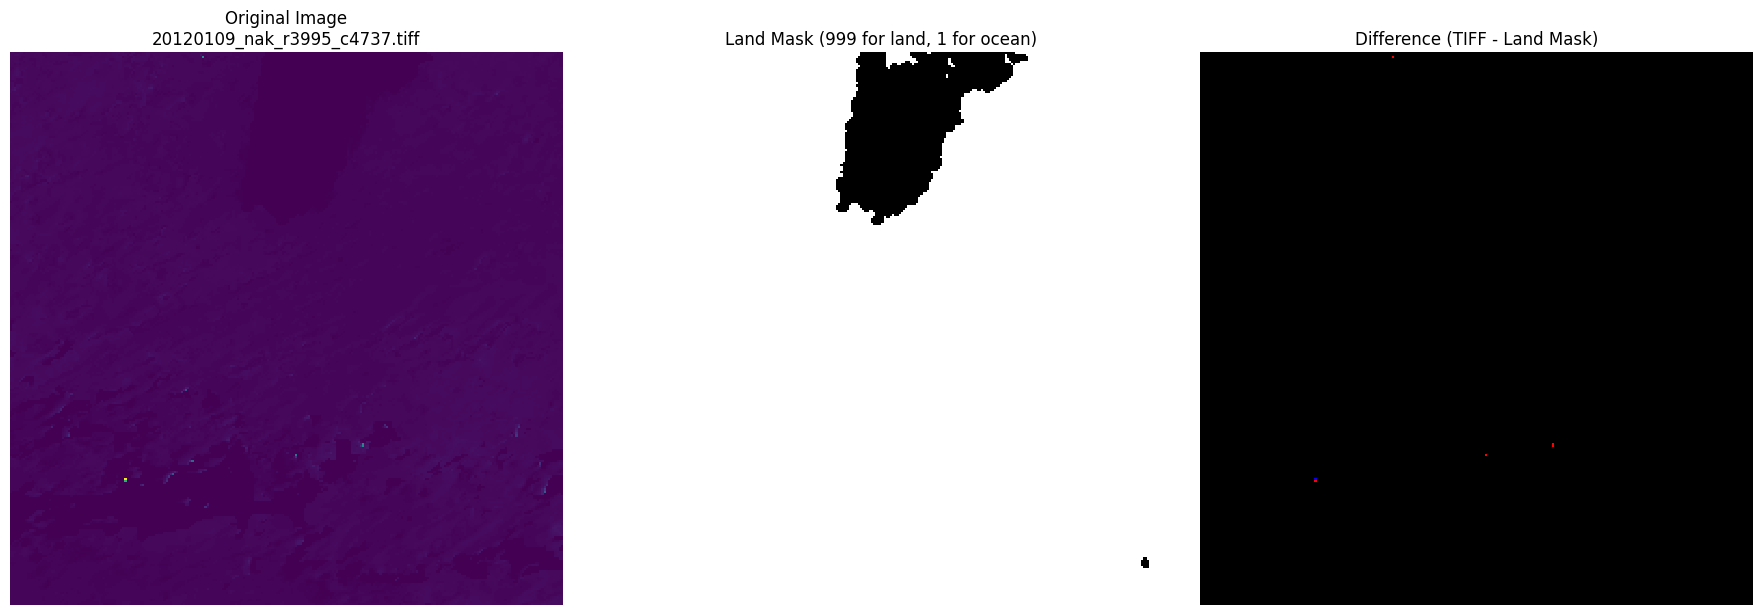

파일명: 20120227_nak_r3898_c4740.tiff
전체 픽셀 수: 65536
TIFF 이미지의 0 값 픽셀 수: 38484
TIFF 이미지의 0 값 비율: 58.72%


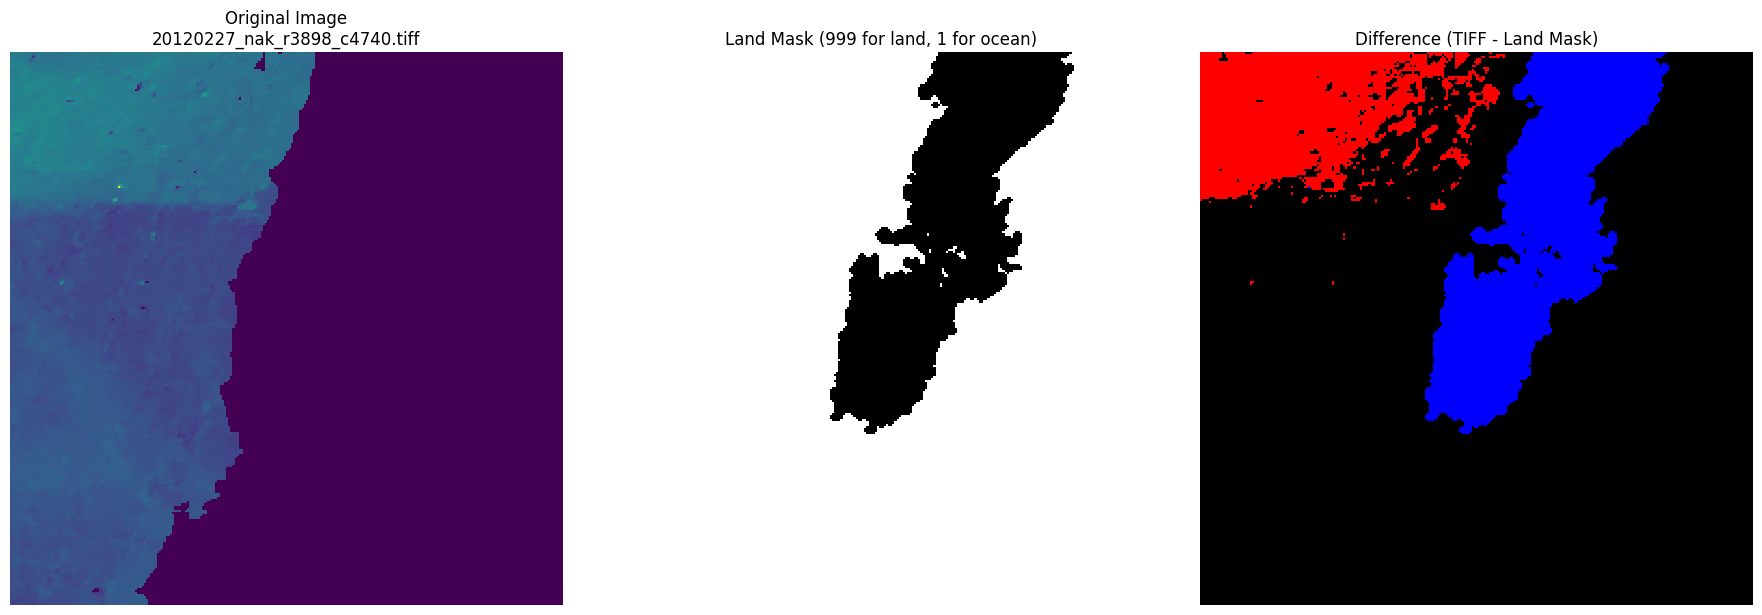

파일명: 20120109_nak_r3995_c4751.tiff
전체 픽셀 수: 65536
TIFF 이미지의 0 값 픽셀 수: 9837
TIFF 이미지의 0 값 비율: 15.01%


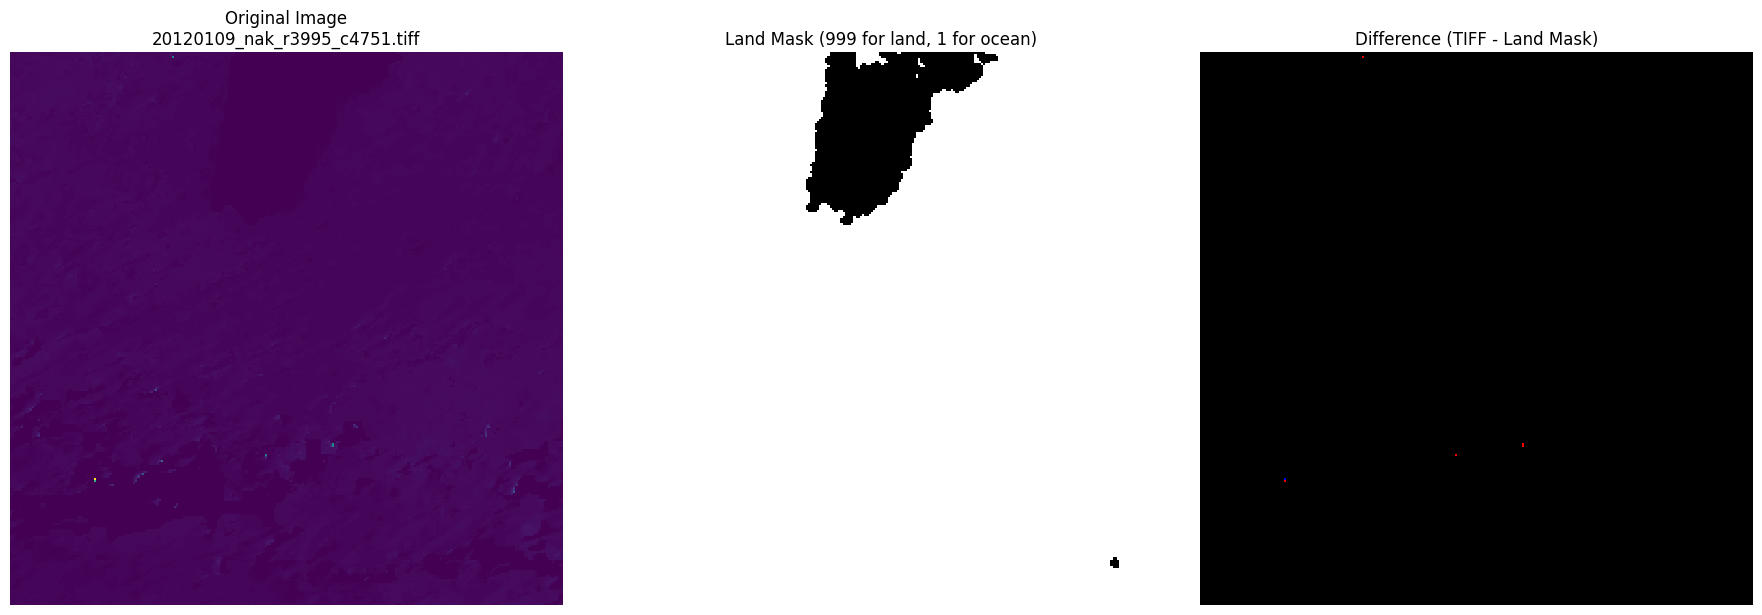

파일명: 20120227_nak_r3908_c4728.tiff
전체 픽셀 수: 65536
TIFF 이미지의 0 값 픽셀 수: 36181
TIFF 이미지의 0 값 비율: 55.21%


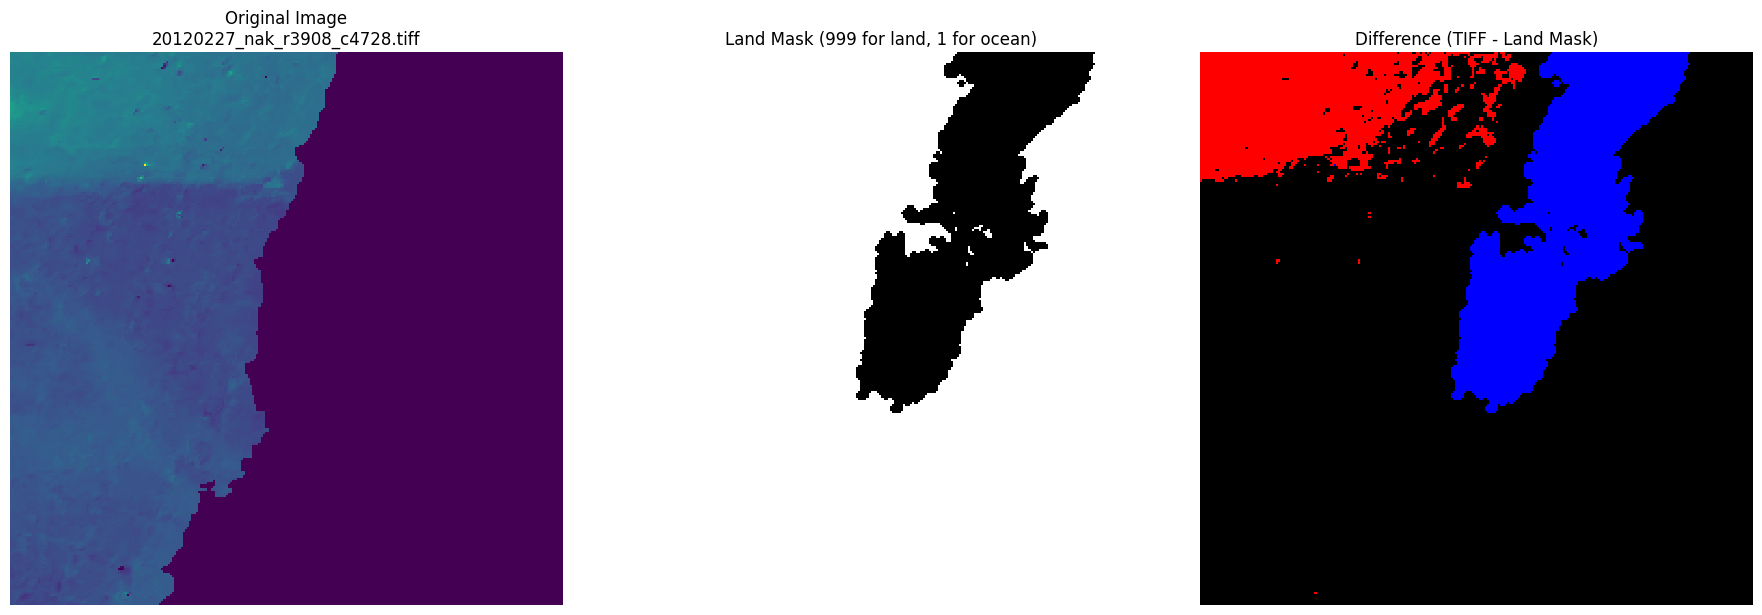

In [72]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.io import loadmat
import re  # 정규 표현식 사용

# 최상위 디렉토리 경로 설정
root_directory = "/home/juneyonglee/Documents"

# 육지/해양 마스크 파일 경로 설정
land_mask_path = "/home/juneyonglee/Desktop/AY_ust/preprocessing/Land_mask/Land_mask.mat"

# MATLAB 파일에서 육지/해양 마스크 불러오기
mat_data = loadmat(land_mask_path)
land_mask = mat_data['Land']  # 실제 MATLAB 파일 내의 변수명 사용

# land_mask의 육지 부분은 999로, 해양 부분은 1로 변환
land_mask = np.where(land_mask == 0, 999, 1)

# 사용자 정의 컬러맵 생성 (해양 데이터용)
def create_custom_cmap():
    viridis = plt.cm.get_cmap('viridis', 256)  # 256개 색상 사용
    return ListedColormap(viridis(np.linspace(0, 1, 256)))

# 사용자 정의 컬러맵 설정
custom_cmap = create_custom_cmap()

# 행(row)과 열(col) 값을 파일명에서 추출하는 함수
def extract_row_col(filename):
    match = re.search(r'r(\d+)_c(\d+)', filename)
    if match:
        row = int(match.group(1))
        col = int(match.group(2))
        return row, col
    return None, None

# 디렉토리 내의 모든 하위 폴더와 파일을 순차적으로 처리
image_count = 0  # 출력할 이미지 카운터
max_images = 20  # 출력할 최대 이미지 수

for dirpath, dirnames, filenames in os.walk(root_directory):
    print(f"현재 폴더: {dirpath}")  # 현재 폴더 경로 출력
    
    # 해당 폴더 내의 모든 tiff 파일을 처리
    for filename in filenames:
        if filename.endswith(".tiff"):  # TIFF 파일만 선택
            file_path = os.path.join(dirpath, filename)
            
            # 파일명에서 행(row)과 열(col) 값 추출
            row, col = extract_row_col(filename)
            if row is None or col is None:
                continue  # 파일명에서 row, col 추출에 실패하면 건너뜀
            
            # 이미지 불러오기
            img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)

            # land_mask에서 해당 위치에 맞는 부분만 자르기 (img의 크기를 고려해서)
            mask_patch = land_mask[row:row+img.shape[0], col:col+img.shape[1]]
            
            if mask_patch.shape != img.shape:
                print(f"Warning: Mask patch shape {mask_patch.shape} does not match image shape {img.shape}")
                continue  # 마스크 패치 크기가 이미지와 맞지 않으면 건너뜀

            # TIFF 이미지에서 0인 값 비율 계산 (전체 대비 비율)
            zero_pixel_count = np.count_nonzero(img == 0)
            total_pixels = img.size
            zero_pixel_percentage = (zero_pixel_count / total_pixels) * 100

            # 육지(999)와 해양(1) 차이 계산
            land_sea_difference = img - mask_patch  # 두 배열 간의 차이
            
            print(f"파일명: {filename}")
            print(f"전체 픽셀 수: {total_pixels}")
            print(f"TIFF 이미지의 0 값 픽셀 수: {zero_pixel_count}")
            print(f"TIFF 이미지의 0 값 비율: {zero_pixel_percentage:.2f}%")
            
            # 2열로 그림을 그리기 위한 설정
            fig, axs = plt.subplots(1, 3, figsize=(18, 6))
            
            # 첫 번째 열: 원본 이미지
            axs[0].imshow(img, cmap=custom_cmap, interpolation='none')
            axs[0].set_title(f"Original Image\n{filename}")
            axs[0].axis('off')  # 축 제거
            
            # 두 번째 열: land_mask 이미지
            axs[1].imshow(mask_patch, cmap=ListedColormap(['black','white']), interpolation='none')
            axs[1].set_title("Land Mask (999 for land, 1 for ocean)")
            axs[1].axis('off')  # 축 제거
            
            # 세 번째 열: 차이 이미지 (두 배열 간의 차이)
            axs[2].imshow(land_sea_difference, cmap=ListedColormap(['black', 'red', 'blue']), interpolation='none')
            axs[2].set_title("Difference (TIFF - Land Mask)")
            axs[2].axis('off')  # 축 제거
            
            # 그래프 출력
            plt.tight_layout()
            plt.show()

            image_count += 1  # 이미지 카운터 증가
            if image_count >= max_images:  # 최대 이미지 수에 도달하면 종료
                break
    if image_count >= max_images:  # 상위 루프에서도 종료
        break
